# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu

# 2. Collect Images

In [2]:
import os
import time
import uuid
import cv2

In [4]:
IMAGES_PATH =os.path.join( 'data' , 'images')
number_images = 20

In [6]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


# 2. Anotate

In [ ]:
!labelme

# 3. Create Dataset

In [ ]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

# 3. All other process

In [ ]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [8]:
images.as_numpy_iterator().next()

b'data\\images\\WIN_20221120_23_47_33_Pro.jpg'

In [9]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [10]:
images = images.map(load_image)

In [11]:
images.as_numpy_iterator().next()

array([[[182, 174, 172],
        [181, 173, 171],
        [180, 172, 169],
        ...,
        [159, 143, 146],
        [160, 141, 145],
        [160, 141, 145]],

       [[181, 173, 171],
        [180, 172, 169],
        [179, 171, 168],
        ...,
        [160, 144, 147],
        [161, 142, 146],
        [161, 142, 146]],

       [[181, 171, 169],
        [180, 170, 168],
        [179, 169, 167],
        ...,
        [161, 145, 148],
        [161, 145, 148],
        [161, 145, 148]],

       ...,

       [[147, 138, 133],
        [146, 137, 132],
        [146, 137, 132],
        ...,
        [138, 134, 125],
        [138, 134, 125],
        [138, 134, 125]],

       [[149, 138, 132],
        [147, 136, 130],
        [147, 136, 130],
        ...,
        [139, 132, 122],
        [137, 133, 122],
        [137, 133, 122]],

       [[150, 139, 133],
        [148, 137, 131],
        [148, 137, 131],
        ...,
        [138, 131, 121],
        [135, 131, 120],
        [135, 131, 120]]

In [12]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 3.1 View Raw Images with Matplotlib

In [13]:
image_generator = images.batch(4).as_numpy_iterator()

In [14]:
plot_images = image_generator.next()

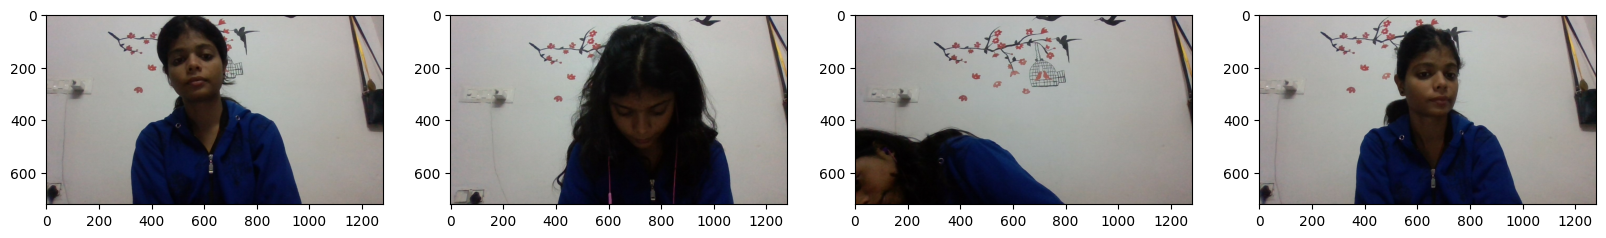

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

### 3.2 Partition into test train and val

In [20]:
39*0.6 #12

23.4

In [21]:
39*0.20

7.800000000000001

In [23]:
39*0.20

7.800000000000001

# 4. Move Matching Labels AFTER Annotation with Labelme

In [24]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

# 5. Image Augmentation

In [16]:
import albumentations as alb

In [17]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                        keypoint_params=alb.KeypointParams(format='xy', label_fields=['class_labels']))

## 5.1 Testing the Augmentation

In [20]:
img = cv2.imread(os.path.join('data','train', 'images','WIN_20221120_23_28_04_Pro.jpg'))

In [21]:
with open(os.path.join('data', 'train', 'labels', 'WIN_20221120_23_28_04_Pro.json'), 'r') as f:
    label = json.load(f)

In [22]:
label['shapes'][0]['points']

[[492.4590163934426, 220.24590163934425]]

In [23]:
## COORDINATES

In [24]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]

In [25]:
coords

[492.4590163934426, 220.24590163934425, 0, 0]

In [26]:
coords = list(np.divide(coords, [640,480,640,480]))

In [27]:
coords

[0.7694672131147541, 0.4588456284153005, 0.0, 0.0]

In [28]:
## APPLY AUGMENTATION AND VIEW PIPELINE

# 6. Build and Run Augmentation Pipeline

In [29]:
for partition in ['train', 'test', 'val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        classes = [0,0]
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
    
            if label['shapes'][0]['label']=='LeftEye': 
                classes[0] = 1
                coords[0] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[1] = np.squeeze(label['shapes'][0]['points'])[1]

            if label['shapes'][0]['label']=='RightEye':
                classes[1] = 1
                coords[2] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[3] = np.squeeze(label['shapes'][0]['points'])[1]

            if len(label['shapes']) > 1:     
                if label['shapes'][1]['label'] =='LeftEye': 
                    classes[0] = 1 
                    coords[0] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[1] = np.squeeze(label['shapes'][1]['points'])[1]

                if label['shapes'][1]['label'] =='RightEye': 
                    classes[1] = 1
                    coords[2] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[3] = np.squeeze(label['shapes'][1]['points'])[1]
            
            np.divide(coords, [640,480,640,480])
                
        try: 
            for x in range(120):
                keypoints = [(coords[:2]), (coords[2:])]
                augmented = augmentor(image=img, keypoints=keypoints, class_labels=['LeftEye','RightEye'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                annotation['class'] = [0,0]
                annotation['keypoints'] = [0,0,0,0]

                if os.path.exists(label_path):
                    if len(augmented['keypoints']) > 0: 
                        for idx, cl in enumerate(augmented['class_labels']):
                            if cl == 'LeftEye': 
                                annotation['class'][0] = 1 
                                annotation['keypoints'][0] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][1] = augmented['keypoints'][idx][1]
                            if cl == 'RightEye': 
                                annotation['class'][1] = 1 
                                annotation['keypoints'][2] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][3] = augmented['keypoints'][idx][1]
                                
                annotation['keypoints'] = list(np.divide(annotation['keypoints'], [450,450,450,450]))


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)